In [1]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib import rc
import astropy.units as u
from astropy import constants as const
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton
import warnings
import time

from scipy.stats.kde import gaussian_kde
from numpy import linspace

import h5py as h5 

from ipywidgets import IntProgress
from IPython.display import display

In [2]:
#Set latex environment for plots/labels
# matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16


In [3]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = fm, second=False, labelpad=None, setMinor=True):
#     matplotlib.rc('font', **{'family': 'serif'})

    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [4]:
hobbs_pathData        = os.environ['SCRATCH']+f'/supernova_remnant_merger_rates/hobbs_2e7_combined.h5'
mm_pathData        = os.environ['SCRATCH'] + f"/supernova_remnant_merger_rates/mm20_520_2e7_combined.h5"


In [5]:
fdata = h5.File(hobbs_pathData, 'r')

SEED = fdata['BSE_System_Parameters']["SEED"][...].squeeze() 
unique, counts = np.unique(SEED, return_counts=True)
print(len(SEED))
print(len(unique))

fdata.close()

20000064
20000064


In [6]:
fdata = h5.File(mm_pathData, 'r')

SEED = fdata['BSE_System_Parameters']["SEED"][...].squeeze() 
unique, counts = np.unique(SEED, return_counts=True)
print(len(SEED))
print(len(unique))

fdata.close()

20000064
20000064


# Spin Up Pulsar Fractions

In [68]:
hobbs_fdata = h5.File(hobbs_pathData, 'r')
# hobbs_fdata = h5.File(mm_pathData, 'r')

unbound = hobbs_fdata['BSE_Supernovae']["Unbound"][...].squeeze() 
sn_type = hobbs_fdata['BSE_Supernovae']["SN_Type(SN)"][...].squeeze()

sn_stellar_type = hobbs_fdata['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
cp_stellar_type = hobbs_fdata['BSE_Supernovae']['Stellar_Type(CP)'][...].squeeze()

sn_velocity = hobbs_fdata['BSE_Supernovae']['ComponentSpeed(SN)'][...].squeeze()
cp_velocity = hobbs_fdata['BSE_Supernovae']['ComponentSpeed(CP)'][...].squeeze()

sma_pre_sn = hobbs_fdata['BSE_Supernovae']['SemiMajorAxis<SN'][...].squeeze()
ecc_pre_sn = hobbs_fdata['BSE_Supernovae']['Eccentricity<SN'][...].squeeze()

seed = hobbs_fdata['BSE_Supernovae']['SEED'][...].squeeze()

hobbs_fdata.close()

In [69]:
sma_lim = (5*u.R_sun).to(u.AU).value
sma_lim

0.023252336304810786

In [70]:
mask_all = ((cp_stellar_type == 13)  *  (sn_stellar_type == 13) * (unbound == 1) * (sma_pre_sn < sma_lim))

In [71]:
mask2 = ((cp_stellar_type == 13)  *  (sn_stellar_type == 13) * (unbound == 1) * (sma_pre_sn > 0))
vel_2_cp = cp_velocity[mask2]
vel_2_sn = sn_velocity[mask2]
vel_2 = np.concatenate([vel_2_cp, vel_2_sn])

sn_2 = sn_type[mask2]
sma_range = sma_pre_sn[mask2]

print(len((seed[mask2])))
print(len(np.unique(seed[mask2])))

15263
15263


In [72]:
print(f"percentage of spin-up pulsars (ejected by second SN) in Hobbs = {100* np.sum(mask2) / np.sum(mask_all):.4f}%")

percentage of spin-up pulsars (ejected by second SN) in Hobbs = 1.0761%


In [73]:
maskSN_NS = ((sn_stellar_type ==13) * (unbound == 1))
ns_velocities_sn = sn_velocity[maskSN_NS]

maskSN_NS_companion = ((cp_stellar_type == 13)* (unbound == 1))
ns_velocities_cp = cp_velocity[maskSN_NS_companion]

print(f"Actual unique pulars = {len(np.unique(seed[maskSN_NS + maskSN_NS_companion]))}")

Actual unique pulars = 5967101


In [74]:
mm_fdata = h5.File(mm_pathData, 'r')

SEED = mm_fdata['BSE_Double_Compact_Objects']["SEED"][...].squeeze() 
unique, indices = np.unique(SEED, return_index=True)

unbound = mm_fdata['BSE_Supernovae']["Unbound"][...].squeeze()[indices]
sn_type = mm_fdata['BSE_Supernovae']["SN_Type(SN)"][...].squeeze()[indices]

sn_stellar_type = mm_fdata['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()[indices]
cp_stellar_type = mm_fdata['BSE_Supernovae']['Stellar_Type(CP)'][...].squeeze()[indices]

sn_velocity = mm_fdata['BSE_Supernovae']['ComponentSpeed(SN)'][...].squeeze()[indices]
cp_velocity = mm_fdata['BSE_Supernovae']['ComponentSpeed(CP)'][...].squeeze()[indices]

sma_pre_sn = mm_fdata['BSE_Supernovae']['SemiMajorAxis<SN'][...].squeeze()[indices]
ecc_pre_sn = mm_fdata['BSE_Supernovae']['Eccentricity<SN'][...].squeeze()[indices]


mm_fdata.close()

In [76]:
mask_all = ((cp_stellar_type == 13)  *  (sn_stellar_type == 13) * (unbound == 1) * (sma_pre_sn < sma_lim))
mask2 = ((cp_stellar_type == 13)  *  (sn_stellar_type == 13) * (unbound == 1) * (sma_pre_sn > 0))
print(f"percentage of spin-up pulsars (ejected by second SN) in MM20 = {100* np.sum(mask2) / np.sum(mask_all):.4f}%")


percentage of spin-up pulsars (ejected by second SN) in MM20 = 0.9571%


# Investigate properties of mergers

To get the eccentricity-period distribution of BNSs, we set dco_type='bns' above, and will select the set of DCOs from the H5 file whose Merges_Hubble_Time==True, Stellar_Type(1)'+ 'Stellar_Type(2)==26.

In [7]:
def mask_type(data, st_type1, st_type2, dco_type='BNS', merge=None):
    masked_data = data
    
    if merge is not None:
        mask_hubble = (merge==True)
        masked_data = masked_data[mask_hubble]
        st_type1 = st_type1[mask_hubble]
        st_type2 = st_type2[mask_hubble]
        
    if dco_type=='BBH':
        st_type_sum = 28
    if dco_type=='BNS':
        st_type_sum = 26
    if dco_type=='BHNS':
        st_type_sum = 27
    if dco_type=='all':
        return masked_data
    
    mask = (st_type1 + st_type2==st_type_sum)
    return masked_data[mask]

In [8]:
# sma in AU
# m1 in M_sun 
# m2 in M_sun
# period in yr

def sma_to_period(sma, m1, m2):
    sma = sma*u.au
    m1 = m1*const.M_sun
    m2 = m2*const.M_sun
    
    return 2*np.pi*np.sqrt((sma**3)/(const.G*(m1+m2))).to(u.yr).value

In [47]:
hobbs_fdata = h5.File(hobbs_pathData, 'r')
hobbs_merge = hobbs_fdata['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][()]

hobbs_m1_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
hobbs_m2_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]

hobbs_type1_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
hobbs_type2_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

hobbs_ecc_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
hobbs_sma_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
hobbs_dco_seed = hobbs_fdata['BSE_Double_Compact_Objects']["SEED"][()]

hobbs_unbound_ALL = hobbs_fdata['BSE_Supernovae']["Unbound"][()]
hobbs_kicks_ALL = hobbs_fdata['BSE_Supernovae']["Applied_Kick_Magnitude(SN)"][()]
hobbs_speeds_ALL = hobbs_fdata['BSE_Supernovae']["ComponentSpeed(SN)"][()]

hobbs_sn_stellartype = hobbs_fdata['BSE_Supernovae']["Stellar_Type(SN)"][()]
hobbs_cp_stellartype = hobbs_fdata['BSE_Supernovae']["Stellar_Type(CP)"][()]

hobbs_sn_sntype = hobbs_fdata['BSE_Supernovae']["SN_Type(SN)"][()]
hobbs_sn_orbital_v = hobbs_fdata['BSE_Supernovae']["Orb_Velocity<SN"][()]

hobbs_sn_sma = hobbs_fdata['BSE_Supernovae']["SemiMajorAxis<SN"][()]
hobbs_sn_mass_sn = hobbs_fdata['BSE_Supernovae']['Mass(SN)'][()]
hobbs_sn_mass_cp = hobbs_fdata['BSE_Supernovae']['Mass(CP)'][()]

hobbs_sn_co_mass = hobbs_fdata['BSE_Supernovae']['Mass_CO_Core@CO(SN)'][()]


hobbs_sn_seed = hobbs_fdata['BSE_Supernovae']["SEED"][()]

hobbs_fdata.close()

In [23]:
mm_fdata = h5.File(mm_pathData, 'r')

# SEED = mm_fdata['BSE_System_Parameters']["SEED"][...].squeeze() 
# unique_all, indices_all = np.unique(SEED, return_index=True)
# print(len(unique_all))

# SEED = mm_fdata['BSE_Double_Compact_Objects']["SEED"][...].squeeze() 
# unique, indices = np.unique(SEED, return_index=True)

mm_merge = mm_fdata['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][()]

mm_m1_ALL = mm_fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
mm_m2_ALL = mm_fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]

mm_type1_ALL = mm_fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
mm_type2_ALL = mm_fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

mm_ecc_ALL = mm_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
mm_sma_ALL = mm_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
mm_dco_seed = mm_fdata['BSE_Double_Compact_Objects']["SEED"][()]


# SEED_sn = mm_fdata['BSE_Supernovae']["SEED"][...].squeeze() 
# sn_indices = np.in1d(SEED_sn, unique_all)

# print(len(SEED_sn))
# print(len(sn_indices))


mm_unbound_ALL = mm_fdata['BSE_Supernovae']["Unbound"][()]
mm_kicks_ALL = mm_fdata['BSE_Supernovae']["Applied_Kick_Magnitude(SN)"][()]
mm_speeds_ALL = mm_fdata['BSE_Supernovae']["ComponentSpeed(SN)"][()]

mm_sn_stellartype = mm_fdata['BSE_Supernovae']["Stellar_Type(SN)"][()]
mm_cp_stellartype = mm_fdata['BSE_Supernovae']["Stellar_Type(CP)"][()]

mm_sn_sntype = mm_fdata['BSE_Supernovae']["SN_Type(SN)"][()]

mm_sn_orbital_v = mm_fdata['BSE_Supernovae']["Orb_Velocity<SN"][()]

mm_sn_sma = mm_fdata['BSE_Supernovae']["SemiMajorAxis<SN"][()]
mm_sn_mass_sn = mm_fdata['BSE_Supernovae']['Mass(SN)'][()]
mm_sn_mass_cp = mm_fdata['BSE_Supernovae']['Mass(CP)'][()]

mm_sn_co_mass = mm_fdata['BSE_Supernovae']['Mass_CO_Core@CO(SN)'][()]


print(mm_fdata['BSE_Supernovae']['Mass(SN)'].attrs['units'])
print(mm_fdata['BSE_Supernovae']["SemiMajorAxis<SN"].attrs['units'])

mm_sn_seed = mm_fdata['BSE_Supernovae']["SEED"][()]

mm_fdata.close()


b'Msol'
b'Rsol'


In [11]:
hobbs_ns_kicks = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)]
mm_ns_kicks = mm_kicks_ALL[(mm_sn_stellartype ==13)]

hobbs_unbound_ns_kicks = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1))]
mm_unbound_ns_kicks = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1))]

hobbs_bound_ns_kicks = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 0))]
mm_bound_ns_kicks = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 0))]

In [12]:
print(f"Total Hobbs Kicks to NS: {len(hobbs_ns_kicks)} ({100*len(hobbs_ns_kicks)/len(hobbs_ns_kicks):.2f}%)")
print(f"Total Hobbs Kicks to NS, Disruptions: {len(hobbs_unbound_ns_kicks)} ({100*len(hobbs_unbound_ns_kicks)/len(hobbs_ns_kicks):.2f}%)")
print(f"Total Hobbs Kicks to NS, Intact: {len(hobbs_bound_ns_kicks)} ({100*len(hobbs_bound_ns_kicks)/len(hobbs_ns_kicks):.2f}%)")

Total Hobbs Kicks to NS: 7961537 (100.00%)
Total Hobbs Kicks to NS, Disruptions: 7385149 (92.76%)
Total Hobbs Kicks to NS, Intact: 576388 (7.24%)


In [13]:
print(f"Total MM20 Kicks to NS: {len(mm_ns_kicks)} ({100*len(mm_ns_kicks)/len(mm_ns_kicks):.2f}%)")
print(f"Total MM20 Kicks to NS, Disruptions: {len(mm_unbound_ns_kicks)} ({100*len(mm_unbound_ns_kicks)/len(mm_ns_kicks):.2f}%)")
print(f"Total MM20 Kicks to NS, Intact: {len(mm_bound_ns_kicks)} ({100*len(mm_bound_ns_kicks)/len(mm_ns_kicks):.2f}%)")


Total MM20 Kicks to NS: 7632277 (100.00%)
Total MM20 Kicks to NS, Disruptions: 7149783 (93.68%)
Total MM20 Kicks to NS, Intact: 482494 (6.32%)


In [14]:
print(f"Hobbs produces {100* (len(hobbs_ns_kicks)-len(mm_ns_kicks))/len(mm_ns_kicks):.2f}% ({len(hobbs_ns_kicks)-len(mm_ns_kicks)}) more SN events than MM20")
print(f"Hobbs produces {100* (len(hobbs_unbound_ns_kicks)-len(mm_unbound_ns_kicks))/len(mm_unbound_ns_kicks):.2f}% ({len(hobbs_unbound_ns_kicks)-len(mm_unbound_ns_kicks)}) more disruptions than MM20")
print(f"Hobbs produces {100* (len(hobbs_bound_ns_kicks)-len(mm_bound_ns_kicks))/len(mm_bound_ns_kicks):.2f}% ({len(hobbs_bound_ns_kicks)-len(mm_bound_ns_kicks)}) more intact NSs than MM20")


Hobbs produces 4.31% (329260) more SN events than MM20
Hobbs produces 3.29% (235366) more disruptions than MM20
Hobbs produces 19.46% (93894) more intact NSs than MM20


## Explaining the impact of USSNe on the Merger Rate

In [22]:
mm_ussn_second_ns = mm_sn_seed[(mm_sn_stellartype==13) * (mm_cp_stellartype==13) * (mm_sn_sntype==16)]
mm_merging_bns = mm_dco_seed[(mm_merge==1) * (mm_type1_ALL+mm_type2_ALL==26)]
mm_ussn_second_ns_merging = mm_ussn_second_ns[np.in1d(mm_ussn_second_ns, mm_merging_bns)]

print(len(mm_ussn_second_ns_merging))
print(len(mm_merging_bns))


print(f"{100* len(mm_ussn_second_ns_merging)/(len(mm_merging_bns)):.2f} BNS systems that would merge in 14 Gyr experience USSN as the second SN in the binary.")

2180
2269
96.08 BNS systems that would merge in 14 Gyr experience USSN as the second SN in the binary.


## Intact BINARIES

In [28]:
mm_bound_ns_binaries = mm_sn_seed[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 0)*(mm_cp_stellartype ==13))]
hobbs_bound_ns_binaries = hobbs_sn_seed[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 0)*(hobbs_cp_stellartype ==13))]

print(f"If all BNSs received 2 kicks, number of binaries in MM20: {len(mm_bound_ns_binaries)}")
print(f"If all BNSs received 2 kicks, number of binaries in Hobbs: {len(hobbs_bound_ns_binaries)}")

print(len(np.unique(mm_bound_ns_binaries)))
print(len(np.unique(hobbs_bound_ns_binaries)))


If all BNSs received 2 kicks, number of binaries in MM20: 1713
If all BNSs received 2 kicks, number of binaries in Hobbs: 713
1713
713


In [23]:
mm_dco_bns = mm_dco_seed[(mm_type1_ALL==13)*(mm_type2_ALL==13)]
hobbs_dco_bns = hobbs_dco_seed[(hobbs_type1_ALL==13)*(hobbs_type2_ALL==13)]

print(f"Number of BNS in MM20: {len(np.unique(mm_dco_bns))}")
print(f"Number of BNS in Hobbs: {len(np.unique(hobbs_dco_bns))}")

Number of BNS in MM20: 4187
Number of BNS in Hobbs: 7462


In [27]:
mm_dco_bns_merge = mm_dco_seed[(mm_type1_ALL==13)*(mm_type2_ALL==13)*(mm_merge==1)]
hobbs_dco_bns_merge = hobbs_dco_seed[(hobbs_type1_ALL==13)*(hobbs_type2_ALL==13)*(hobbs_merge==1)]

print(f"Number of BNS in MM20 Mergers: {len(np.unique(mm_dco_bns_merge))}")
print(f"Number of BNS in Hobbs Mergers: {len(np.unique(hobbs_dco_bns_merge))}")

Number of BNS in MM20 Mergers: 2269
Number of BNS in Hobbs Mergers: 3344


# What fraction of NSs would be ejected from GCs?

In [17]:
hobbs_ns_speeds = hobbs_speeds_ALL[(hobbs_sn_stellartype == 13)]
mm_ns_speeds = mm_speeds_ALL[(mm_sn_stellartype == 13)]

In [18]:
print(f"{100 * ((np.sum(hobbs_ns_speeds<50)/len(hobbs_ns_speeds))):.2f}% of Hobbs NSs remain in clusters.")
print(f"{100 * ((np.sum(mm_ns_speeds<50)/len(mm_ns_speeds))):.2f}% of MM20 NSs remain in clusters.")

6.66% of Hobbs NSs remain in clusters.
6.21% of MM20 NSs remain in clusters.


## What fraction of Binary disruptions are [SN Type]?

In [19]:
snTypeDict = {
    1: 'CCSN',
    2: 'ECSN',
    16: 'USSN'
} 
sn_type_check = 16

In [20]:
for sn_type_check in snTypeDict:
    hobbs_unbound_by_sn = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1)*(hobbs_sn_sntype==sn_type_check))]
    mm_unbound_by_sn = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1)*(mm_sn_sntype==sn_type_check))]

    hobbs_all_kicks_by_sn = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_sn_sntype==sn_type_check))]
    mm_all_kicks_by_sn = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_sn_sntype==sn_type_check))]

    print(f"{100*len(hobbs_unbound_by_sn)/len(hobbs_all_kicks_by_sn):.2f}% of Hobbs stars were disrupted by {snTypeDict[sn_type_check]}, i.e. {len(hobbs_unbound_by_sn)} disruptions")
    print(f"{100*len(mm_unbound_by_sn)/len(mm_all_kicks_by_sn):.2f}% of MM20 stars were disrupted by {snTypeDict[sn_type_check]}, i.e. {len(mm_unbound_by_sn)} disruptions")
    print()

98.11% of Hobbs stars were disrupted by CCSN, i.e. 7218063 disruptions
97.67% of MM20 stars were disrupted by CCSN, i.e. 6855418 disruptions

52.35% of Hobbs stars were disrupted by ECSN, i.e. 163100 disruptions
56.50% of MM20 stars were disrupted by ECSN, i.e. 177271 disruptions

1.36% of Hobbs stars were disrupted by USSN, i.e. 3986 disruptions
39.05% of MM20 stars were disrupted by USSN, i.e. 117094 disruptions



In [21]:
for sn_type_check in snTypeDict:
    hobbs_unbound_ns_kicks = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1))]
    mm_unbound_ns_kicks = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1))]

    hobbs_unbound_by_sn = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1)*(hobbs_sn_sntype==sn_type_check))]
    mm_unbound_by_sn = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1)*(mm_sn_sntype==sn_type_check))]


    print(f"{100*len(hobbs_unbound_by_sn)/len(hobbs_unbound_ns_kicks):.2f}% of Hobbs disruptions were caused by {snTypeDict[sn_type_check]}, i.e. {len(hobbs_unbound_by_sn)} disruptions")
    print(f"{100*len(mm_unbound_by_sn)/len(mm_unbound_ns_kicks):.2f}% of MM20 disruptions were caused by {snTypeDict[sn_type_check]}, i.e. {len(mm_unbound_by_sn)} disruptions")
    print()

97.74% of Hobbs disruptions were caused by CCSN, i.e. 7218063 disruptions
95.88% of MM20 disruptions were caused by CCSN, i.e. 6855418 disruptions

2.21% of Hobbs disruptions were caused by ECSN, i.e. 163100 disruptions
2.48% of MM20 disruptions were caused by ECSN, i.e. 177271 disruptions

0.05% of Hobbs disruptions were caused by USSN, i.e. 3986 disruptions
1.64% of MM20 disruptions were caused by USSN, i.e. 117094 disruptions



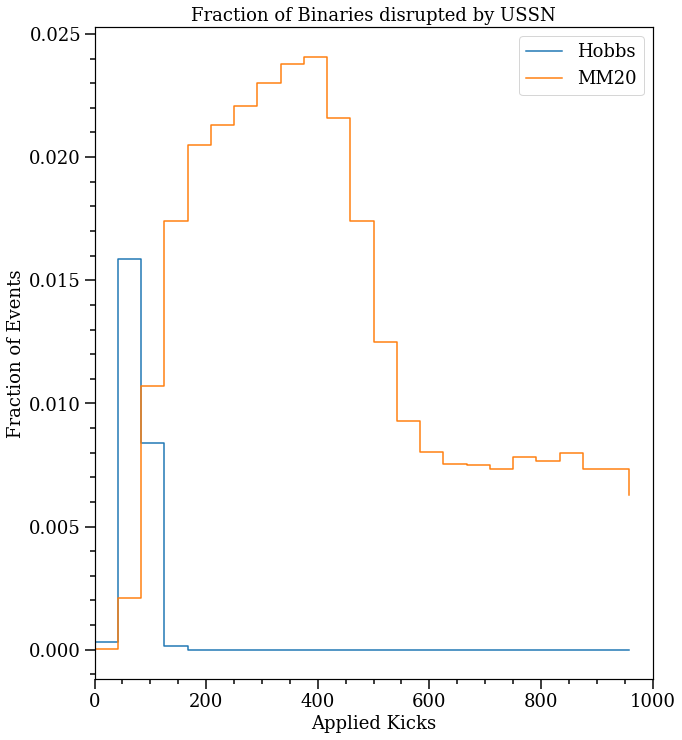

In [22]:
bins = np.linspace(0, 1000, 25)
hobbs_disruptions_binned, binss = np.histogram(hobbs_unbound_ns_kicks, bins=bins)
hobbs_sn_disruptions_binned, binss = np.histogram(hobbs_unbound_by_sn, bins=bins)
hobbs_sn_type_disruption_frac = hobbs_sn_disruptions_binned/hobbs_disruptions_binned

mm_disruptions_binned, binss = np.histogram(mm_unbound_ns_kicks, bins=bins)
mm_sn_disruptions_binned, binss = np.histogram(mm_unbound_by_sn, bins=bins)
mm_sn_type_disruption_frac = mm_sn_disruptions_binned/mm_disruptions_binned

f, (ax)= plt.subplots(1, 1,  figsize=(10,12)) 

layoutAxes(ax=ax, nameX='Applied Kicks',\
           nameY='Fraction of Events')

ax.step(binss[:-1], hobbs_sn_type_disruption_frac, where='post', label="Hobbs")
ax.step(binss[:-1], mm_sn_type_disruption_frac, where='post', label="MM20")

ax.legend(fontsize=fm)
ax.set_title(f"Fraction of Binaries disrupted by {snTypeDict[sn_type_check]}", fontsize=fm)
ax.set_xlim(0, 1000)

plt.show()


# USSN Plots

Ilya: For NS USSN in binaries with another NS, can you do a scatter plot showing the applied kick velocity against the CO core mass, using different colours or symbols for binaries that are disrupted by the kick vs. those that remain intact?

In [56]:
mm_ussn_second_ns_mask = (mm_sn_stellartype==13) * (mm_cp_stellartype==13) * (mm_sn_sntype==16)

mm_second_ussn_applied_kick_disrupted = mm_kicks_ALL[mm_ussn_second_ns_mask*(mm_unbound_ALL==1)]
mm_second_ussn_applied_co_core_disrupted = mm_sn_co_mass[mm_ussn_second_ns_mask*(mm_unbound_ALL==1)]

mm_second_ussn_applied_kick_bound = mm_kicks_ALL[mm_ussn_second_ns_mask*(mm_unbound_ALL==0)]
mm_second_ussn_applied_co_core_bound = mm_sn_co_mass[mm_ussn_second_ns_mask*(mm_unbound_ALL==0)]

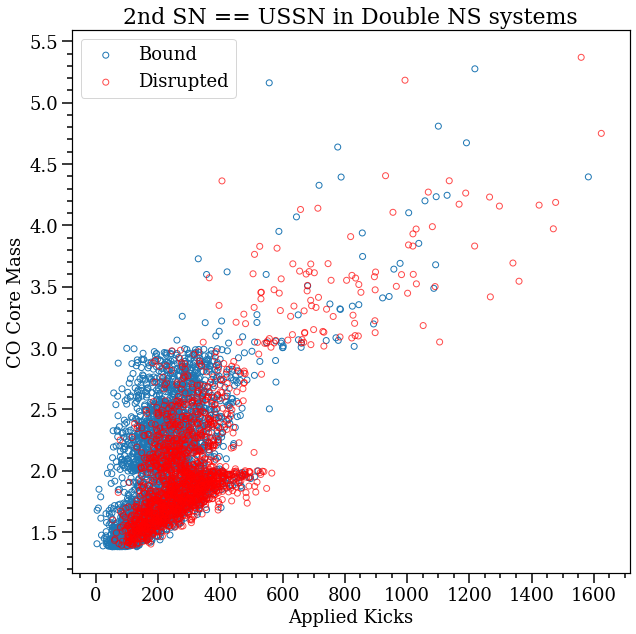

In [57]:
f, (ax)= plt.subplots(1, 1,  figsize=(10,10)) 

layoutAxes(ax=ax, nameX='Applied Kicks',\
           nameY='CO Core Mass')

plt.scatter(mm_second_ussn_applied_kick_bound, mm_second_ussn_applied_co_core_bound, label='Bound',  facecolors='none', edgecolors='C0')
plt.scatter(mm_second_ussn_applied_kick_disrupted, mm_second_ussn_applied_co_core_disrupted, label='Disrupted', facecolors='none', edgecolors='r', alpha=0.7)

ax.legend(fontsize=fm)
plt.title("2nd SN == USSN in Double NS systems", fontsize=fl)
plt.show()


In [48]:
hobbs_ussn_second_ns_mask = (hobbs_sn_stellartype==13) * (hobbs_cp_stellartype==13) * (hobbs_sn_sntype==16)

hobbs_second_ussn_applied_kick_disrupted = hobbs_kicks_ALL[hobbs_ussn_second_ns_mask*(hobbs_unbound_ALL==1)]
hobbs_second_ussn_applied_co_core_disrupted = hobbs_sn_co_mass[hobbs_ussn_second_ns_mask*(hobbs_unbound_ALL==1)]

hobbs_second_ussn_applied_kick_bound = hobbs_kicks_ALL[hobbs_ussn_second_ns_mask*(hobbs_unbound_ALL==0)]
hobbs_second_ussn_applied_co_core_bound = hobbs_sn_co_mass[hobbs_ussn_second_ns_mask*(hobbs_unbound_ALL==0)]

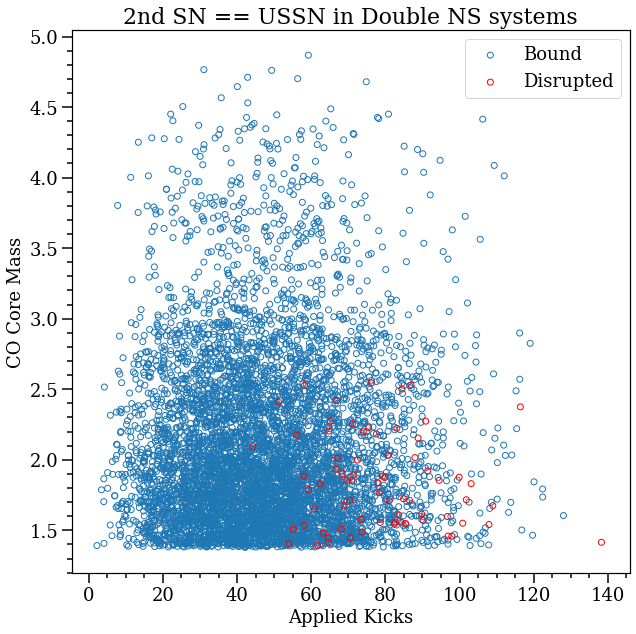

In [50]:
f, (ax)= plt.subplots(1, 1,  figsize=(10,10)) 

layoutAxes(ax=ax, nameX='Applied Kicks',\
           nameY='CO Core Mass')

plt.scatter(hobbs_second_ussn_applied_kick_bound, hobbs_second_ussn_applied_co_core_bound, label='Bound',  facecolors='none', edgecolors='C0')
plt.scatter(hobbs_second_ussn_applied_kick_disrupted, hobbs_second_ussn_applied_co_core_disrupted, label='Disrupted', facecolors='none', edgecolors='r', alpha=1)

ax.legend(fontsize=fm)
plt.title("2nd SN == USSN in Double NS systems", fontsize=fl)
plt.show()


## See the Kick distribution of unbound objects

In [23]:
hobbs_unbound_ns_kicks = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1))]
mm_unbound_ns_kicks = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1))]

hobbs_bound_ns_kicks = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 0))]
mm_bound_ns_kicks = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 0))]

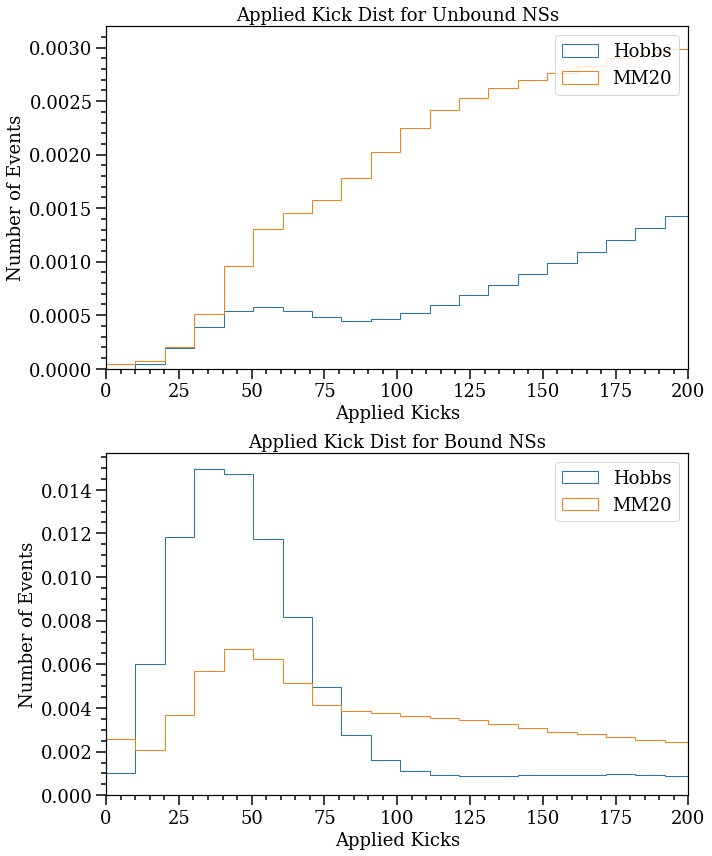

In [24]:
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(10,12)) 

layoutAxes(ax=ax1, nameX='Applied Kicks',\
           nameY='Number of Events')

layoutAxes(ax=ax2, nameX='Applied Kicks',\
           nameY='Number of Events')


bins = np.linspace(0, 1000, 100)

ax1.hist(hobbs_unbound_ns_kicks, bins=bins, histtype='step', density=True, label="Hobbs")
ax1.hist(mm_unbound_ns_kicks, bins=bins, histtype='step',  density=True, label="MM20")
ax1.legend(fontsize=fm)
ax1.set_title("Applied Kick Dist for Unbound NSs", fontsize=fm)
ax1.set_xlim(0, 200)

ax2.hist(hobbs_bound_ns_kicks, bins=bins, histtype='step', density=True, label="Hobbs")
ax2.hist(mm_bound_ns_kicks, bins=bins, histtype='step',  density=True, label="MM20")
ax2.legend(fontsize=fm)
ax2.set_title("Applied Kick Dist for Bound NSs", fontsize=fm)
ax2.set_xlim(0, 200)
plt.tight_layout()
plt.show()

## Break Down Kicks by SN Type

In [23]:
hobbs_unbound_ns_kicks = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1))]
mm_unbound_ns_kicks = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1))]

hobbs_bound_ns_kicks = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 0))]
mm_bound_ns_kicks = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 0))]

In [24]:
snTypeDict = {
    1: 'CCSN',
    2: 'ECSN',
    16: 'USSN'
} 

In [25]:
for sn_type_check in snTypeDict:
    hobbs_unbound_by_sn_type = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1)*(hobbs_sn_sntype==sn_type_check))]
    mm_unbound_by_sn_type = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1)*(mm_sn_sntype==sn_type_check))]

    print(f"Hobbs leaves {100* (len(hobbs_unbound_by_sn_type)-len(mm_unbound_by_sn_type))/len(mm_unbound_by_sn_type):.2f}% ({(len(hobbs_unbound_by_sn_type)-len(mm_unbound_by_sn_type))}) more binaries disrupted following {snTypeDict[sn_type_check]} than MM20")
    

Hobbs leaves -47.36% (-6492773) more binaries disrupted following CCSN than MM20
Hobbs leaves -54.00% (-191442) more binaries disrupted following ECSN than MM20
Hobbs leaves -98.30% (-230202) more binaries disrupted following USSN than MM20


In [26]:
for sn_type_check in snTypeDict:
    hobbs_bound_by_sn_type = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 0)*(hobbs_sn_sntype==sn_type_check))]
    mm_bound_by_sn_type = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 0)*(mm_sn_sntype==sn_type_check))]

    print(f"Hobbs leaves {100* (len(hobbs_bound_by_sn_type)-len(mm_bound_by_sn_type))/len(mm_bound_by_sn_type):.2f}% ({(len(hobbs_bound_by_sn_type)-len(mm_bound_by_sn_type))}) more binaries intact following {snTypeDict[sn_type_check]} than MM20")
    

Hobbs leaves -57.38% (-187372) more binaries intact following CCSN than MM20
Hobbs leaves -45.61% (-124500) more binaries intact following ECSN than MM20
Hobbs leaves -20.99% (-76728) more binaries intact following USSN than MM20


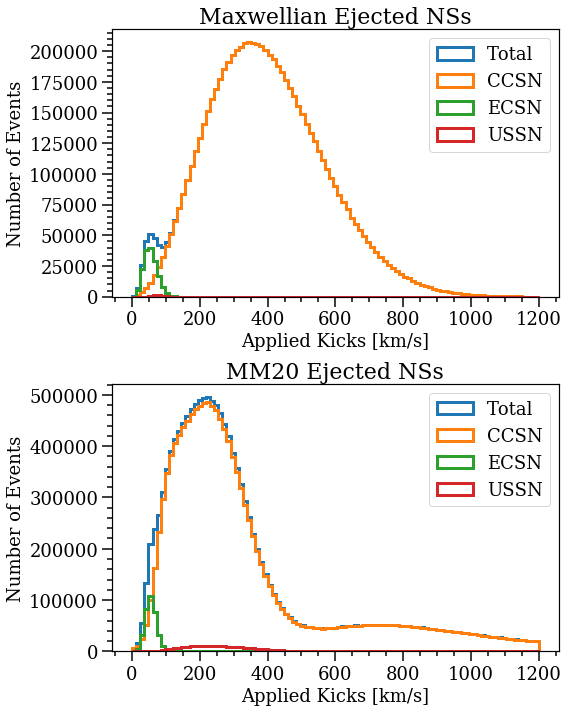

In [27]:
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(8,10)) 

layoutAxes(ax=ax1, nameX='Applied Kicks [km/s]',\
           nameY='Number of Events')

layoutAxes(ax=ax2, nameX='Applied Kicks [km/s]',\
           nameY='Number of Events')

bins = np.linspace(0, 1200, 100)

lw=3

hobbs_norm = len(hobbs_unbound_ns_kicks)
mm_norm = len(mm_unbound_ns_kicks)


ax1.hist(hobbs_unbound_ns_kicks, bins=bins, histtype='step', lw=lw, density=False, label="Total")
ax2.hist(mm_unbound_ns_kicks, bins=bins, histtype='step',  lw=lw, density=False, label="Total")

for sn_type_check in snTypeDict:
    hobbs_kick_by_sn_type = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1)*(hobbs_sn_sntype==sn_type_check))]
    mm_kick_by_sn_type = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1)*(mm_sn_sntype==sn_type_check))]

    
    ax1.hist(hobbs_kick_by_sn_type, bins=bins, histtype='step', lw=lw, density=False, label=f"{snTypeDict[sn_type_check]}")
    ax2.hist(mm_kick_by_sn_type, bins=bins, histtype='step', lw=lw, density=False, label=f"{snTypeDict[sn_type_check]}")


ax1.legend(fontsize=fm)
ax2.legend(fontsize=fm)
# ax1.set_xlim(0, 1000)
# ax2.set_xlim(0, 1000)

# ax1.set_ylim(0, 1)
# ax2.set_ylim(0, 1)
ax1.set_title("Maxwellian Ejected NSs", fontsize=fl)
ax2.set_title("MM20 Ejected NSs", fontsize=fl)
plt.tight_layout()
plt.show()

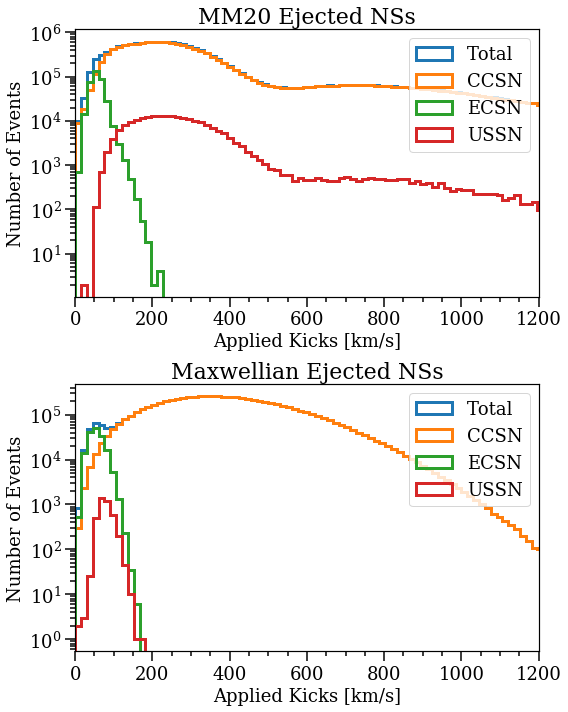

In [28]:
# Paper Plot
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(8,10)) 

layoutAxes(ax=ax1, nameX='Applied Kicks [km/s]',\
           nameY='Number of Events')

layoutAxes(ax=ax2, nameX='Applied Kicks [km/s]',\
           nameY='Number of Events')

bins = np.linspace(0, 1500, 100)

lw=3

hobbs_norm = len(hobbs_unbound_ns_kicks)
mm_norm = len(mm_unbound_ns_kicks)

ax1.hist(mm_unbound_ns_kicks, bins=bins, histtype='step',  lw=lw, density=False, label="Total")
ax2.hist(hobbs_unbound_ns_kicks, bins=bins, histtype='step', lw=lw, density=False, label="Total")

for sn_type_check in snTypeDict:
    hobbs_kick_by_sn_type = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1)*(hobbs_sn_sntype==sn_type_check))]
    mm_kick_by_sn_type = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1)*(mm_sn_sntype==sn_type_check))]

    ax1.hist(mm_kick_by_sn_type, bins=bins, histtype='step', lw=lw, density=False, label=f"{snTypeDict[sn_type_check]}")
    ax2.hist(hobbs_kick_by_sn_type, bins=bins, histtype='step', lw=lw, density=False, label=f"{snTypeDict[sn_type_check]}")


ax1.legend(fontsize=fm)
ax2.legend(fontsize=fm)

ax1.set_yscale("log")
ax2.set_yscale("log")

ax1.set_xlim(0, 1200)
ax2.set_xlim(0, 1200)

# ax1.set_ylim(0, 250000)
# ax2.set_ylim(0, 250000)

ax1.set_title("MM20 Ejected NSs", fontsize=fl)
ax2.set_title("Maxwellian Ejected NSs", fontsize=fl)
plt.tight_layout()

# plt.savefig('plots/merger_rate_applied_kick_by_ns.pdf')
plt.show()

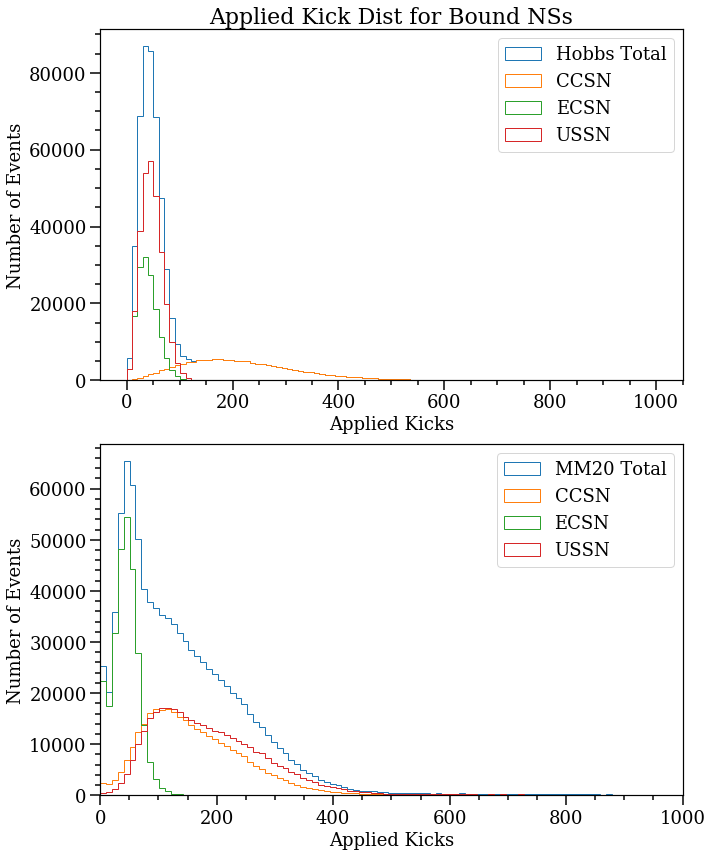

In [29]:
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(10,12)) 

layoutAxes(ax=ax1, nameX='Applied Kicks',\
           nameY='Number of Events')

layoutAxes(ax=ax2, nameX='Applied Kicks',\
           nameY='Number of Events')

bins = np.linspace(0, 1000, 100)

ax1.hist(hobbs_bound_ns_kicks, bins=bins, histtype='step', density=False, label="Hobbs Total")
ax2.hist(mm_bound_ns_kicks, bins=bins, histtype='step',  density=False, label="MM20 Total")

for sn_type_check in snTypeDict:
    hobbs_kick_by_sn_type = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 0)*(hobbs_sn_sntype==sn_type_check))]
    mm_kick_by_sn_type = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 0)*(mm_sn_sntype==sn_type_check))]

    
    ax1.hist(hobbs_kick_by_sn_type, bins=bins, histtype='step', density=False, label=snTypeDict[sn_type_check])
    ax2.hist(mm_kick_by_sn_type, bins=bins, histtype='step', density=False, label=snTypeDict[sn_type_check])


ax1.legend(fontsize=fm)
ax2.legend(fontsize=fm)
plt.xlim(0, 1000)
ax1.set_title("Applied Kick Dist for Bound NSs", fontsize=fl)

plt.tight_layout()
plt.show()

# Orbital Velocities

In [30]:
hobbs_unbound_orbital_v = hobbs_sn_orbital_v[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1))]
mm_unbound_orbital_v = mm_sn_orbital_v[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1))]

hobbs_bound_orbital_v = hobbs_sn_orbital_v[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 0))]
mm_bound_orbital_v = mm_sn_orbital_v[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 0))]

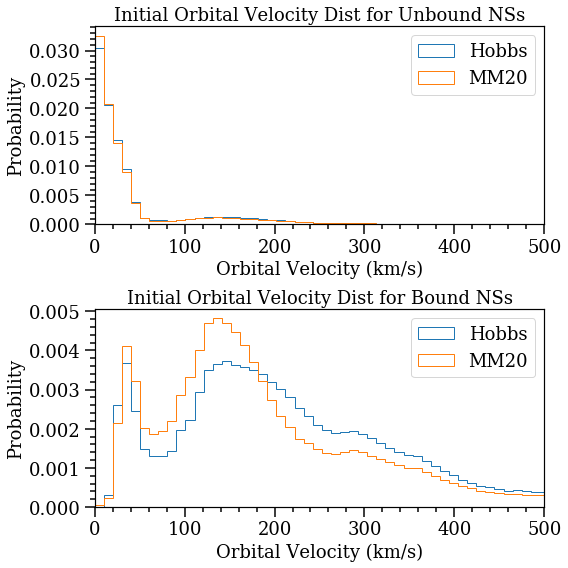

In [31]:
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(8,8)) 

layoutAxes(ax=ax1, nameX='Orbital Velocity (km/s)',\
           nameY='Probability')
layoutAxes(ax=ax2, nameX='Orbital Velocity (km/s)',\
           nameY='Probability')

bins = np.linspace(0, 1000, 100)

ax1.hist(hobbs_unbound_orbital_v, bins=bins, histtype='step', density=True, label="Hobbs")
ax1.hist(mm_unbound_orbital_v, bins=bins, histtype='step',  density=True, label="MM20")
ax1.legend(fontsize=fm)
ax1.set_title("Initial Orbital Velocity Dist for Unbound NSs", fontsize=fm)
ax1.set_xlim(0, 500)

ax2.hist(hobbs_bound_orbital_v, bins=bins, histtype='step', density=True, label="Hobbs")
ax2.hist(mm_bound_orbital_v, bins=bins, histtype='step',  density=True, label="MM20")
ax2.legend(fontsize=fm)
ax2.set_title("Initial Orbital Velocity Dist for Bound NSs", fontsize=fm)
ax2.set_xlim(0, 500)

plt.tight_layout()
plt.show()

## Applied kicks to Orbital velocity ratio

In [32]:
hobbs_orbital_v_ns = hobbs_sn_orbital_v[(hobbs_sn_stellartype ==13)]
mm_orbital_v_ns = mm_sn_orbital_v[(mm_sn_stellartype ==13)]

hobbs_kicks_ns = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)]
mm_kicks_ns = mm_kicks_ALL[(mm_sn_stellartype ==13)]

tot_hobbs_kick_orbital_ratio = hobbs_kicks_ns/hobbs_orbital_v_ns
tot_mm_kick_orbital_ratio = mm_kicks_ns/mm_orbital_v_ns

In [33]:
sum(tot_hobbs_kick_orbital_ratio>1)

5380545

In [34]:
sum(tot_mm_kick_orbital_ratio>1)

11266140

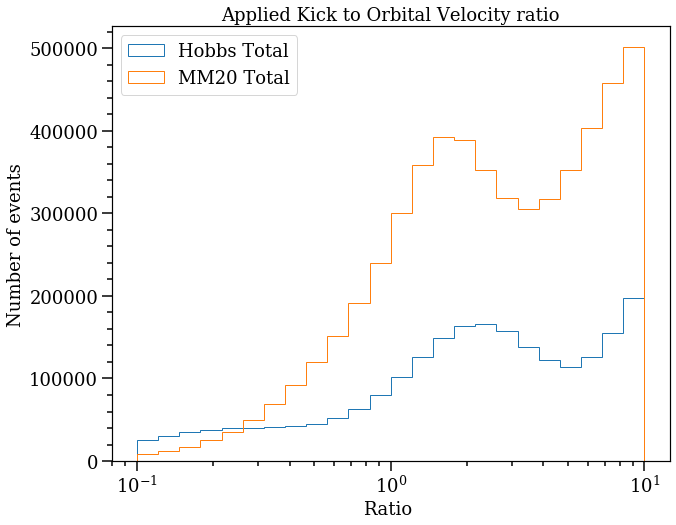

In [35]:
f, (ax1)= plt.subplots(1, 1,  figsize=(10,8)) 

bins=np.logspace(-1, 1, 25)

layoutAxes(ax=ax1, nameX='Ratio ',\
           nameY='Number of events')

ax1.hist(tot_hobbs_kick_orbital_ratio, bins=bins, histtype='step', label="Hobbs Total")
ax1.hist(tot_mm_kick_orbital_ratio, bins=bins, histtype='step', label="MM20 Total")

plt.title("Applied Kick to Orbital Velocity ratio", fontsize=fm)
plt.legend(fontsize=fm, loc='upper left')
plt.semilogx()
plt.show()

In [36]:
print(len(tot_hobbs_kick_orbital_ratio))
print(len(tot_mm_kick_orbital_ratio))

7961537
15264554


In [37]:
hobbs_orbital_v_ns = hobbs_sn_orbital_v[(hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL==1)]
mm_orbital_v_ns = mm_sn_orbital_v[(mm_sn_stellartype ==13)*(mm_unbound_ALL==1)]

hobbs_kicks_ns = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL==1)]
mm_kicks_ns = mm_kicks_ALL[(mm_sn_stellartype ==13)*(mm_unbound_ALL==1)]

tot_hobbs_kick_orbital_ratio_unbound = hobbs_kicks_ns/hobbs_orbital_v_ns
tot_mm_kick_orbital_ratio_unbound = mm_kicks_ns/mm_orbital_v_ns

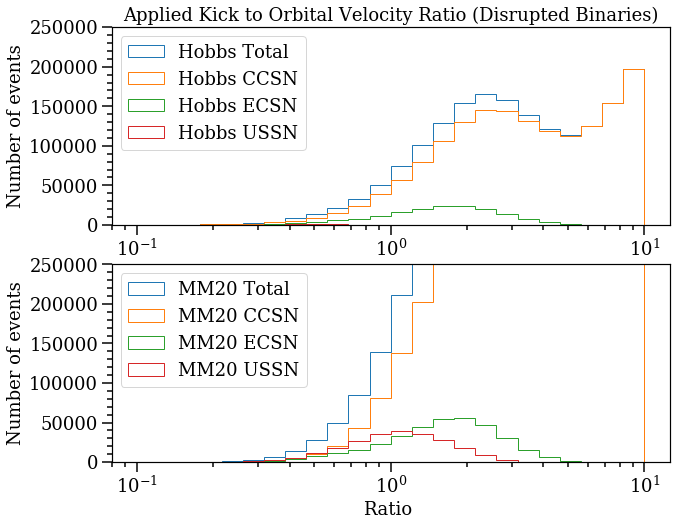

In [38]:
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(10,8)) 

bins=np.logspace(-1, 1, 25)

layoutAxes(ax=ax1, nameX='Ratio ',\
           nameY='Number of events')

layoutAxes(ax=ax2, nameX='Ratio ',\
           nameY='Number of events')

ax1.hist(tot_hobbs_kick_orbital_ratio_unbound, bins=bins, histtype='step', label="Hobbs Total")
ax2.hist(tot_mm_kick_orbital_ratio_unbound, bins=bins, histtype='step', label="MM20 Total")

for sn_type_check in snTypeDict:
    hobbs_orbital_v_ns = hobbs_sn_orbital_v[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL==1)* (hobbs_sn_sntype == sn_type_check)]
    mm_orbital_v_ns = mm_sn_orbital_v[(mm_sn_stellartype ==13)* (mm_unbound_ALL==1)* (mm_sn_sntype == sn_type_check)]
    
    hobbs_kicks_ns = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)* (hobbs_unbound_ALL==1)*(hobbs_sn_sntype == sn_type_check)]
    mm_kicks_ns = mm_kicks_ALL[(mm_sn_stellartype ==13)* (mm_unbound_ALL==1)*(mm_sn_sntype == sn_type_check)]

    hobbs_kick_orbital_ratio = hobbs_kicks_ns/hobbs_orbital_v_ns
    mm_kick_orbital_ratio = mm_kicks_ns/mm_orbital_v_ns
    
    ax1.hist(hobbs_kick_orbital_ratio, bins=bins, histtype='step', label=f"Hobbs {snTypeDict[sn_type_check]}")
    ax2.hist(mm_kick_orbital_ratio, bins=bins, histtype='step', label=f"MM20 {snTypeDict[sn_type_check]}")

ax1.set_title("Applied Kick to Orbital Velocity Ratio (Disrupted Binaries)", fontsize=fm)
ax1.legend(fontsize=fm, loc='upper left')
ax1.semilogx()
ax1.set_ylim(0, 250000)


ax2.legend(fontsize=fm, loc='upper left')
ax2.semilogx()
ax2.set_ylim(0, 250000)

plt.show()

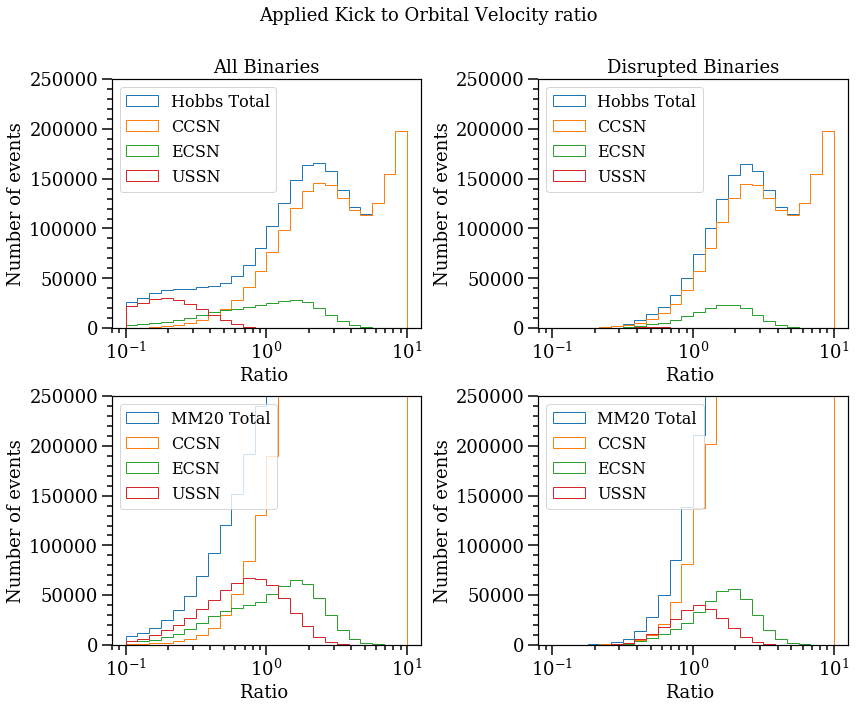

In [39]:
fig, ((ax1, ax3), (ax2, ax4))= plt.subplots(2, 2,  figsize=(12,10)) 

bins=np.logspace(-1, 1, 25)

layoutAxes(ax=ax1, nameX='Ratio ',\
           nameY='Number of events')

layoutAxes(ax=ax2, nameX='Ratio ',\
           nameY='Number of events')

layoutAxes(ax=ax3, nameX='Ratio ',\
           nameY='Number of events')

layoutAxes(ax=ax4, nameX='Ratio ',\
           nameY='Number of events')

ax1.hist(tot_hobbs_kick_orbital_ratio, bins=bins, histtype='step', label="Hobbs Total")
ax2.hist(tot_mm_kick_orbital_ratio, bins=bins, histtype='step', label="MM20 Total")

ax3.hist(tot_hobbs_kick_orbital_ratio_unbound, bins=bins, histtype='step', label="Hobbs Total")
ax4.hist(tot_mm_kick_orbital_ratio_unbound, bins=bins, histtype='step', label="MM20 Total")


for sn_type_check in snTypeDict:
    hobbs_orbital_v_ns = hobbs_sn_orbital_v[(hobbs_sn_stellartype ==13) * (hobbs_sn_sntype == sn_type_check)]
    mm_orbital_v_ns = mm_sn_orbital_v[(mm_sn_stellartype ==13)* (mm_sn_sntype == sn_type_check)]
    
    hobbs_kicks_ns = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)* (hobbs_sn_sntype == sn_type_check)]
    mm_kicks_ns = mm_kicks_ALL[(mm_sn_stellartype ==13)* (mm_sn_sntype == sn_type_check)]

    hobbs_kick_orbital_ratio = hobbs_kicks_ns/hobbs_orbital_v_ns
    mm_kick_orbital_ratio = mm_kicks_ns/mm_orbital_v_ns
    
    ax1.hist(hobbs_kick_orbital_ratio, bins=bins, histtype='step', label=f"{snTypeDict[sn_type_check]}")
    ax2.hist(mm_kick_orbital_ratio, bins=bins, histtype='step', label=f"{snTypeDict[sn_type_check]}")
    
    hobbs_orbital_v_ns = hobbs_sn_orbital_v[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL==1)* (hobbs_sn_sntype == sn_type_check)]
    mm_orbital_v_ns = mm_sn_orbital_v[(mm_sn_stellartype ==13)* (mm_unbound_ALL==1)* (mm_sn_sntype == sn_type_check)]
    
    hobbs_kicks_ns = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)* (hobbs_unbound_ALL==1)*(hobbs_sn_sntype == sn_type_check)]
    mm_kicks_ns = mm_kicks_ALL[(mm_sn_stellartype ==13)* (mm_unbound_ALL==1)*(mm_sn_sntype == sn_type_check)]

    hobbs_kick_orbital_ratio = hobbs_kicks_ns/hobbs_orbital_v_ns
    mm_kick_orbital_ratio = mm_kicks_ns/mm_orbital_v_ns
    
    ax3.hist(hobbs_kick_orbital_ratio, bins=bins, histtype='step', label=f"{snTypeDict[sn_type_check]}")
    ax4.hist(mm_kick_orbital_ratio, bins=bins, histtype='step', label=f"{snTypeDict[sn_type_check]}")

fig.suptitle("Applied Kick to Orbital Velocity ratio", fontsize=fm)

ax1.set_title("All Binaries", fontsize=fm)
ax1.legend(fontsize=fs, loc='upper left')
ax1.semilogx()
ax1.set_ylim(0, 250000)

ax2.legend(fontsize=fs, loc='upper left')
ax2.semilogx()
ax2.set_ylim(0, 250000)


ax3.set_title("Disrupted Binaries", fontsize=fm)
ax3.legend(fontsize=fs, loc='upper left')
ax3.semilogx()
ax3.set_ylim(0, 250000)


ax4.legend(fontsize=fs, loc='upper left')
ax4.semilogx()
ax4.set_ylim(0, 250000)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()



## What percentage of Supernovae keep (future) BNS systems intact in the two cases?

In [40]:
mm_future_bns_seeds_dco = mask_type(mm_dco_seed, mm_type1_ALL, mm_type2_ALL, dco_type='BNS', merge=mm_merge)
print(mm_future_bns_seeds_dco)
print(len(mm_future_bns_seeds_dco))

mm_future_bns_seeds_sn_mask = np.in1d(mm_sn_seed, mm_future_bns_seeds_dco)
mm_future_bns_seeds_sn = mm_sn_seed[mm_future_bns_seeds_sn_mask]

print(mm_future_bns_seeds_sn)
print(len(mm_future_bns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[    1782     4816    29835 ... 39934902 39945326 39955362]
2269
[18665943 18665943 18667016 ... 21542289 21548778 21548778]
9076


In [41]:
hobbs_future_bns_seeds_dco = mask_type(hobbs_dco_seed, hobbs_type1_ALL, hobbs_type2_ALL, dco_type='BNS', merge=hobbs_merge)
print(hobbs_future_bns_seeds_dco)
print(len(hobbs_future_bns_seeds_dco))

hobbs_future_bns_seeds_sn_mask = np.in1d(hobbs_sn_seed, hobbs_future_bns_seeds_dco)
hobbs_future_bns_seeds_sn = hobbs_sn_seed[hobbs_future_bns_seeds_sn_mask]

print(hobbs_future_bns_seeds_sn)
print(len(hobbs_future_bns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[18665943 18667016 18674379 ... 24673454 24680667 24684340]
3344
[18665943 18665943 18667016 ... 24680667 24684340 24684340]
6688


In [42]:
mm_kicks_ns = mm_kicks_ALL[(mm_sn_stellartype ==13)]
mm_kicks_bns_bound = mm_kicks_ALL[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bns_seeds_sn_mask]

mm_bns_percentage = (len(mm_kicks_bns_bound)/len(mm_kicks_ns)*100)
print(f"{mm_bns_percentage:.2f}% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BNS")

hobbs_kicks_ns = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)]
hobbs_kicks_bns_bound = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bns_seeds_sn_mask]

hobbs_bns_percentage = (len(hobbs_kicks_bns_bound)/len(hobbs_kicks_ns)*100)

print(f"{hobbs_bns_percentage:.2f}% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BNS")


0.06% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BNS
0.08% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BNS


In [43]:
printnp.sum((mm_sn_stellartype ==13) * (mm_unbound_ALL == 1)))
printnp.sum((mm_sn_stellartype ==13)))
printnp.sum((hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 1)))
printnp.sum((hobbs_sn_stellartype ==13)))

SyntaxError: invalid syntax (<ipython-input-43-763e210ab6c1>, line 1)

## What percentage of Supernovae keep (future) BHNS systems intact in the two cases?

In [55]:
mm_future_bhns_seeds_dco = mask_type(mm_dco_seed, mm_type1_ALL, mm_type2_ALL, dco_type='BHNS', merge=mm_merge)
print(mm_future_bhns_seeds_dco)
print(len(mm_future_bhns_seeds_dco))

mm_future_bhns_seeds_sn_mask = np.in1d(mm_sn_seed, mm_future_bhns_seeds_dco)
mm_future_bhns_seeds_sn = mm_sn_seed[mm_future_bhns_seeds_sn_mask]

print(mm_future_bhns_seeds_sn)
print(len(mm_future_bhns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[    1022     2093     3379 ... 39948471 39950967 39951193]
11800
[    1022     2093     3379 ... 39948471 39950967 39951193]
11800


In [56]:
hobbs_future_bhns_seeds_dco = mask_type(hobbs_dco_seed, hobbs_type1_ALL, hobbs_type2_ALL, dco_type='BHNS', merge=hobbs_merge)
print(hobbs_future_bhns_seeds_dco)
print(len(hobbs_future_bhns_seeds_dco))

hobbs_future_bhns_seeds_sn_mask = np.in1d(hobbs_sn_seed, hobbs_future_bhns_seeds_dco)
hobbs_future_bhns_seeds_sn = hobbs_sn_seed[hobbs_future_bhns_seeds_sn_mask]

print(hobbs_future_bhns_seeds_sn)
print(len(hobbs_future_bhns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[18661287 18665543 18666364 ... 24671380 24673753 24680230]
6622
[18661287 18661287 18665543 ... 24673753 24680230 24680230]
13244


In [57]:
mm_kicks_ns = mm_kicks_ALL[(mm_sn_stellartype ==13)]
mm_kicks_bhns_bound = mm_kicks_ALL[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bhns_seeds_sn_mask]

mm_bhns_percentage = (len(mm_kicks_bhns_bound)/len(mm_kicks_ns)*100)
print(f"{mm_bhns_percentage:.2f}% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BHNS")

hobbs_kicks_ns = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)]
hobbs_kicks_bhns_bound = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bhns_seeds_sn_mask]

hobbs_bhns_percentage = (len(hobbs_kicks_bhns_bound)/len(hobbs_kicks_ns)*100)

print(f"{hobbs_bhns_percentage:.2f}% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BHNS")


0.01% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BHNS
0.08% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BHNS


I don't get it. Why should the number of BNS and BHNS systems left intact by Hobbs be the same? Shouldn't more BHNS systems survive due to higher required kicks to disrupt?

# What is the initial Energy Distribution of Binaries left intact?

## Gravitational Energy Dist

Energy = $\frac{-GM_1 M_2}{2a}$, where $a$ is the semi-major axis.

In [60]:
mm_masks_bns = ((mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bns_seeds_sn_mask)
mm_bns_bound_init_sma = mm_sn_sma[mm_masks_bns]
mm_bns_m1 = mm_sn_mass_sn[mm_masks_bns]
mm_bns_m2 = mm_sn_mass_cp[mm_masks_bns]
mm_bns_bound_init_energy = (const.G * mm_bns_m1*u.M_sun * mm_bns_m2*u.M_sun) / (2*mm_bns_bound_init_sma*u.R_sun)
mm_bns_bound_init_energy = mm_bns_bound_init_energy.to(u.Joule).value

hobbs_masks_bns = ((hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bns_seeds_sn_mask)
hobbs_bns_bound_init_sma = hobbs_sn_sma[hobbs_masks_bns]
hobbs_bns_m1 = hobbs_sn_mass_sn[hobbs_masks_bns]
hobbs_bns_m2 = hobbs_sn_mass_cp[hobbs_masks_bns]
hobbs_bns_bound_init_energy = (const.G * hobbs_bns_m1*u.M_sun * hobbs_bns_m2*u.M_sun) / (2*hobbs_bns_bound_init_sma*u.R_sun)
hobbs_bns_bound_init_energy = hobbs_bns_bound_init_energy.to(u.Joule).value

mm_masks_bhns = ((mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bhns_seeds_sn_mask)
mm_bhns_bound_init_sma = mm_sn_sma[mm_masks_bhns]
mm_bhns_m1 = mm_sn_mass_sn[mm_masks_bhns]
mm_bhns_m2 = mm_sn_mass_cp[mm_masks_bhns]
mm_bhns_bound_init_energy = (const.G * mm_bhns_m1*u.M_sun * mm_bhns_m2*u.M_sun) / (2*mm_bhns_bound_init_sma*u.R_sun)
mm_bhns_bound_init_energy = mm_bhns_bound_init_energy.to(u.Joule).value

hobbs_masks_bhns = ((hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bhns_seeds_sn_mask)
hobbs_bhns_bound_init_sma = hobbs_sn_sma[hobbs_masks_bhns]
hobbs_bhns_m1 = hobbs_sn_mass_sn[hobbs_masks_bhns]
hobbs_bhns_m2 = hobbs_sn_mass_cp[hobbs_masks_bhns]
hobbs_bhns_bound_init_energy = (const.G * hobbs_bhns_m1*u.M_sun * hobbs_bhns_m2*u.M_sun) / (2*hobbs_bhns_bound_init_sma*u.R_sun)
hobbs_bhns_bound_init_energy = hobbs_bhns_bound_init_energy.to(u.Joule).value



mm_masks_unbound_ns = (mm_sn_stellartype ==13) * (mm_unbound_ALL == 1)
mm_kicks_unbound = mm_kicks_ALL[mm_masks_unbound_ns]
mm_unbound_init_sma = mm_sn_sma[mm_masks_unbound_ns]
mm_m1 = mm_sn_mass_sn[mm_masks_unbound_ns ]
mm_m2 = mm_sn_mass_cp[mm_masks_unbound_ns]
mm_unbound_init_energy = (const.G * mm_m1*u.M_sun * mm_m2*u.M_sun) / (2*mm_unbound_init_sma*u.R_sun)
mm_unbound_init_energy = mm_unbound_init_energy.to(u.Joule).value

hobbs_masks_unbound_ns = (hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 1)
hobbs_kicks_unbound = hobbs_kicks_ALL[hobbs_masks_unbound_ns]
hobbs_unbound_init_sma = hobbs_sn_sma[hobbs_masks_unbound_ns]
hobbs_m1 = hobbs_sn_mass_sn[hobbs_masks_unbound_ns]
hobbs_m2 = hobbs_sn_mass_cp[hobbs_masks_unbound_ns]
hobbs_unbound_init_energy = (const.G * hobbs_m1*u.M_sun * hobbs_m2*u.M_sun) / (2*hobbs_unbound_init_sma*u.R_sun)
hobbs_unbound_init_energy = hobbs_unbound_init_energy.to(u.Joule).value


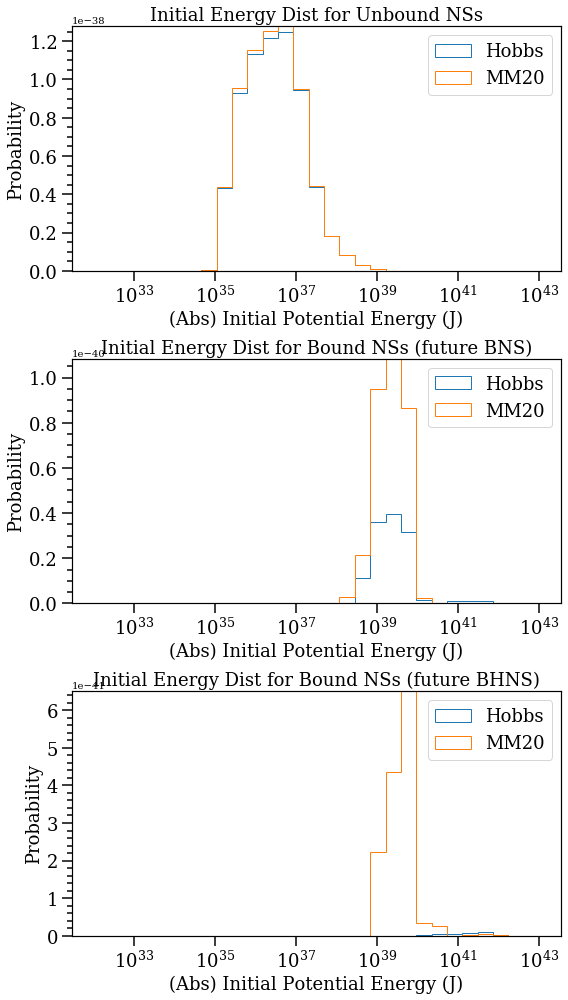

In [61]:
f, (ax1, ax2, ax3)= plt.subplots(3, 1,  figsize=(8,14)) 

layoutAxes(ax=ax1, nameX='(Abs) Initial Potential Energy (J)',\
           nameY='Probability')
layoutAxes(ax=ax2, nameX='(Abs) Initial Potential Energy (J)',\
           nameY='Probability')
layoutAxes(ax=ax3, nameX='(Abs) Initial Potential Energy (J)',\
           nameY='Probability')

bins = np.logspace(32, 43, 30)

ax1.hist(hobbs_unbound_init_energy, bins=bins, histtype='step', density=True, label="Hobbs")
ax1.hist(mm_unbound_init_energy, bins=bins, histtype='step',  density=True, label="MM20")
ax1.legend(fontsize=fm)
ax1.set_title("Initial Energy Dist for Unbound NSs", fontsize=fm)
ax1.set_xscale('log')

ax2.hist(hobbs_bns_bound_init_energy, bins=bins, histtype='step', density=True, label="Hobbs")
ax2.hist(mm_bns_bound_init_energy, bins=bins, histtype='step',  density=True, label="MM20")
ax2.legend(fontsize=fm)
ax2.set_title("Initial Energy Dist for Bound NSs (future BNS)", fontsize=fm)
ax2.set_xscale('log')

ax3.hist(hobbs_bhns_bound_init_energy, bins=bins, histtype='step', density=True, label="Hobbs")
ax3.hist(mm_bhns_bound_init_energy, bins=bins, histtype='step',  density=True, label="MM20")
ax3.legend(fontsize=fm)
ax3.set_title("Initial Energy Dist for Bound NSs (future BHNS)", fontsize=fm)
ax3.set_xscale('log')

plt.tight_layout()
plt.show()

NameError: name 'hobbs_unbound_init_energy_all' is not defined

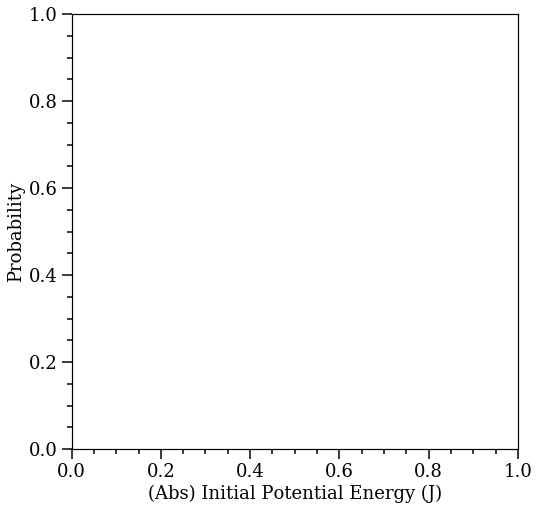

In [62]:
f, (ax1)= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax1, nameX='(Abs) Initial Potential Energy (J)',\
           nameY='Probability')

bins = np.logspace(32, 42, 30)

ax1.hist(hobbs_unbound_init_energy_all, bins=bins, histtype='step', density=True, label="Hobbs")
ax1.hist(mm_unbound_init_energy_all, bins=bins, histtype='step',  density=True, label="MM20")
ax1.legend(fontsize=fm)
ax1.set_title("Initial Energy Dist for Unbound Stars", fontsize=fm)
ax1.set_xscale('log')


plt.tight_layout()
plt.show()

## Orbital Velocity vs Kick

NameError: name 'hobbs_bhns_bound_init_vel' is not defined

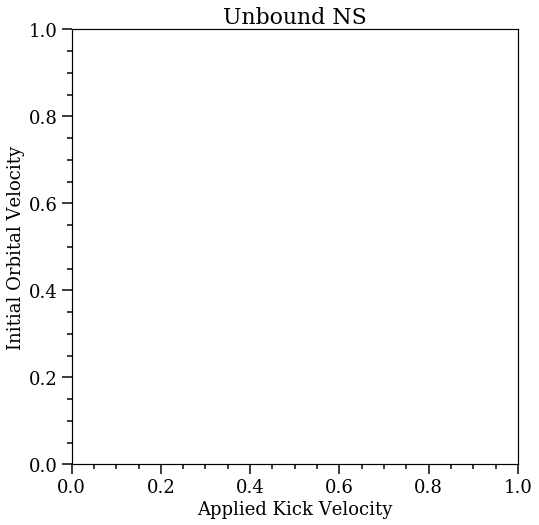

In [63]:
mm_unbound_init_vel = mm_sn_orbital_v[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 1)]
hobbsunbound_init_vel = hobbs_sn_orbital_v[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 1)]

f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax, nameX='Applied Kick Velocity',\
           nameY='Initial Orbital Velocity')

plt.title("Unbound NS", fontsize=fl)

plt.scatter(hobbs_kicks_bhns_bound, hobbs_bhns_bound_init_vel, s=ms, label='Hobbs')
plt.scatter(mm_kicks_bhns_bound, mm_bhns_bound_init_vel, s=ms, label='MM20')


x = np.linspace(0, 2000, 10)
plt.plot(x, x, 'r--', alpha=0.7)

plt.xlim(0, 2000)
plt.ylim(0, 2000)

plt.legend(fontsize=fm)
plt.show()

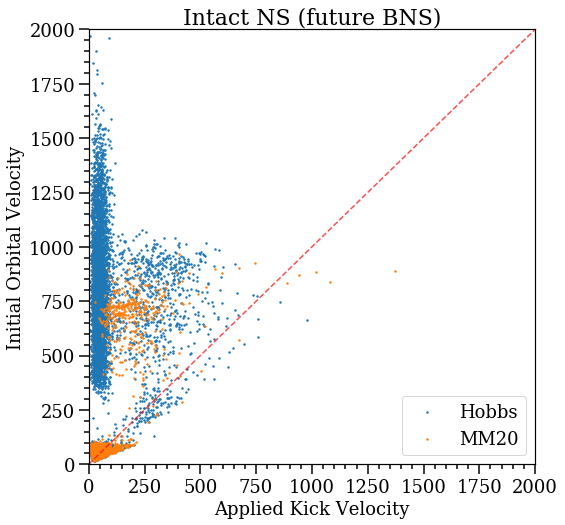

In [64]:
mm_bns_bound_init_vel = mm_sn_orbital_v[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bns_seeds_sn_mask]
hobbs_bns_bound_init_vel = hobbs_sn_orbital_v[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bns_seeds_sn_mask]

ms = 2

f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax, nameX='Applied Kick Velocity',\
           nameY='Initial Orbital Velocity')

plt.title("Intact NS (future BNS)", fontsize=fl)

plt.scatter(hobbs_kicks_bns_bound, hobbs_bns_bound_init_vel, s=ms, label='Hobbs')
plt.scatter(mm_kicks_bns_bound, mm_bns_bound_init_vel, s=ms, label='MM20')


x = np.linspace(0, 2000, 10)
plt.plot(x, x, 'r--', alpha=0.7)

plt.xlim(0, 2000)
plt.ylim(0, 2000)

plt.legend(fontsize=fm)
plt.show()



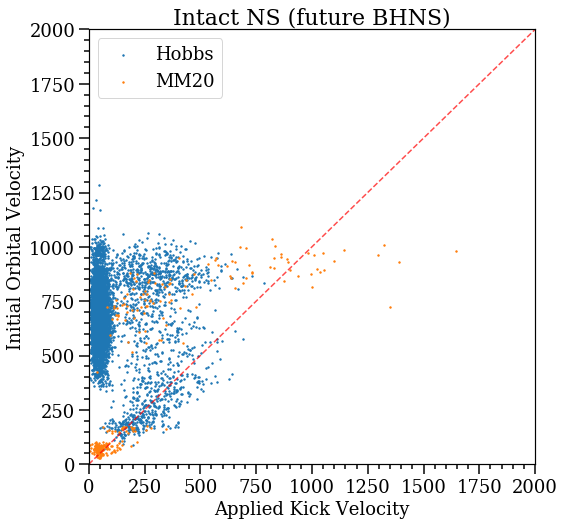

In [65]:
mm_bhns_bound_init_vel = mm_sn_orbital_v[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bhns_seeds_sn_mask]
hobbs_bhns_bound_init_vel = hobbs_sn_orbital_v[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bhns_seeds_sn_mask]

ms=2

f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax, nameX='Applied Kick Velocity',\
           nameY='Initial Orbital Velocity')

plt.title("Intact NS (future BHNS)", fontsize=fl)

plt.scatter(hobbs_kicks_bhns_bound, hobbs_bhns_bound_init_vel, s=ms, label='Hobbs')
plt.scatter(mm_kicks_bhns_bound, mm_bhns_bound_init_vel, s=ms, label='MM20')


x = np.linspace(0, 2000, 10)
plt.plot(x, x, 'r--', alpha=0.7)

plt.xlim(0, 2000)
plt.ylim(0, 2000)

plt.legend(fontsize=fm)
plt.show()




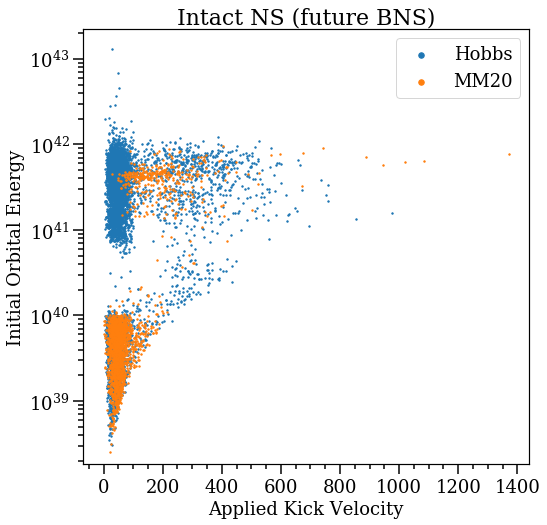

In [66]:
ms = 2

f, ax1= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax1, nameX='Applied Kick Velocity',\
           nameY='Initial Orbital Energy')



ax1.set_title("Intact NS (future BNS)", fontsize=fl)

ax1.scatter(hobbs_kicks_bns_bound, hobbs_bns_bound_init_energy, s=ms, label='Hobbs')
ax1.scatter(mm_kicks_bns_bound, mm_bns_bound_init_energy, s=ms, label='MM20')


plt.semilogy()

lgnd = plt.legend(scatterpoints=1, fontsize=fm)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.show()




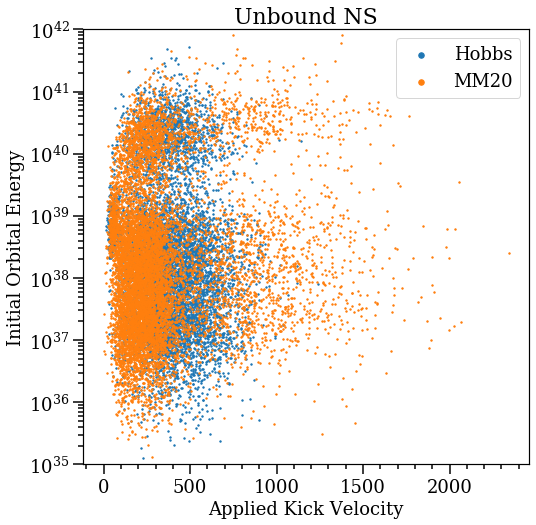

In [67]:
ms = 2

f, ax1= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax1, nameX='Applied Kick Velocity',\
           nameY='Initial Orbital Energy')

ax1.set_title("Unbound NS", fontsize=fl)
N = 10000
ax1.scatter(hobbs_kicks_unbound[:N], hobbs_unbound_init_energy[:N], s=ms, label='Hobbs')
ax1.scatter(mm_kicks_unbound[:N], mm_unbound_init_energy[:N], s=ms, label='MM20')

plt.semilogy()
plt.ylim(1e35, 1e42)


lgnd = plt.legend(scatterpoints=1, fontsize=fm)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

plt.show()




In [68]:
threshold = 80
mm_tot = len(mm_kicks_unbound[::10])
mm_below_t =np.sum(mm_kicks_unbound < threshold)

In [69]:
hobbs_tot = len(hobbs_kicks_unbound[::10])
hobbs_below_t =np.sum(hobbs_kicks_unbound < threshold)

In [70]:
print(f"MM20 kicks out {100* (mm_below_t/hobbs_below_t - 1.0):.2f}% more NS below {threshold} km/s.")
print(f"For reference, MM20 produces {100* (1.0 - 15.04/24.67):.2f}% fewer NS mergers.")

MM20 kicks out 63.48% more NS below 80 km/s.
For reference, MM20 produces 39.04% fewer NS mergers.


In [71]:
mm_sampled = mm_kicks_unbound[::10]
vels = np.linspace(0, 2000, 40)
mm_cdf = np.zeros(len(vels))

for i in range(len(vels)):
    mm_cdf[i] =np.sum(mm_sampled < vels[i])

In [72]:
for i in range(len(vels)):
    print(f"{100*mm_cdf[i]/len(mm_sampled):.2f}% of MM20 kicks (unbound) are below {vels[i]:.0f} km/s")

0.00% of MM20 kicks (unbound) are below 0 km/s
2.13% of MM20 kicks (unbound) are below 51 km/s
10.52% of MM20 kicks (unbound) are below 103 km/s
22.65% of MM20 kicks (unbound) are below 154 km/s
36.57% of MM20 kicks (unbound) are below 205 km/s
51.03% of MM20 kicks (unbound) are below 256 km/s
63.45% of MM20 kicks (unbound) are below 308 km/s
72.11% of MM20 kicks (unbound) are below 359 km/s
77.13% of MM20 kicks (unbound) are below 410 km/s
79.85% of MM20 kicks (unbound) are below 462 km/s
81.51% of MM20 kicks (unbound) are below 513 km/s
82.84% of MM20 kicks (unbound) are below 564 km/s
84.18% of MM20 kicks (unbound) are below 615 km/s
85.61% of MM20 kicks (unbound) are below 667 km/s
87.13% of MM20 kicks (unbound) are below 718 km/s
88.61% of MM20 kicks (unbound) are below 769 km/s
90.05% of MM20 kicks (unbound) are below 821 km/s
91.39% of MM20 kicks (unbound) are below 872 km/s
92.60% of MM20 kicks (unbound) are below 923 km/s
93.72% of MM20 kicks (unbound) are below 974 km/s
94.72

In [73]:
for i in range(len(vels)):
    print(f"{mm_cdf[i]:.0f} MM20 kicks (unbound) are below {vels[i]:.0f} km/s")

0 MM20 kicks (unbound) are below 0 km/s
10924 MM20 kicks (unbound) are below 51 km/s
53995 MM20 kicks (unbound) are below 103 km/s
116219 MM20 kicks (unbound) are below 154 km/s
187670 MM20 kicks (unbound) are below 205 km/s
261854 MM20 kicks (unbound) are below 256 km/s
325630 MM20 kicks (unbound) are below 308 km/s
370040 MM20 kicks (unbound) are below 359 km/s
395787 MM20 kicks (unbound) are below 410 km/s
409792 MM20 kicks (unbound) are below 462 km/s
418263 MM20 kicks (unbound) are below 513 km/s
425092 MM20 kicks (unbound) are below 564 km/s
431982 MM20 kicks (unbound) are below 615 km/s
439339 MM20 kicks (unbound) are below 667 km/s
447111 MM20 kicks (unbound) are below 718 km/s
454711 MM20 kicks (unbound) are below 769 km/s
462134 MM20 kicks (unbound) are below 821 km/s
468996 MM20 kicks (unbound) are below 872 km/s
475192 MM20 kicks (unbound) are below 923 km/s
480934 MM20 kicks (unbound) are below 974 km/s
486082 MM20 kicks (unbound) are below 1026 km/s
490514 MM20 kicks (unb

In [74]:
hobbs_sampled = hobbs_kicks_unbound[::10]
vels = np.linspace(0, 2000, 40)
hobbs_cdf = np.zeros(len(vels))

for i in range(len(vels)):
    hobbs_cdf[i] =np.sum(hobbs_sampled < vels[i])

In [75]:
for i in range(len(vels)):
    print(f"{100*hobbs_cdf[i]/len(hobbs_sampled):.2f}% of Hobbs kicks (unbound) are below {vels[i]:.0f} km/s")

0.00% of Hobbs kicks (unbound) are below 0 km/s
1.22% of Hobbs kicks (unbound) are below 51 km/s
3.81% of Hobbs kicks (unbound) are below 103 km/s
7.46% of Hobbs kicks (unbound) are below 154 km/s
13.75% of Hobbs kicks (unbound) are below 205 km/s
22.66% of Hobbs kicks (unbound) are below 256 km/s
33.50% of Hobbs kicks (unbound) are below 308 km/s
45.17% of Hobbs kicks (unbound) are below 359 km/s
56.79% of Hobbs kicks (unbound) are below 410 km/s
67.39% of Hobbs kicks (unbound) are below 462 km/s
76.48% of Hobbs kicks (unbound) are below 513 km/s
83.73% of Hobbs kicks (unbound) are below 564 km/s
89.23% of Hobbs kicks (unbound) are below 615 km/s
93.13% of Hobbs kicks (unbound) are below 667 km/s
95.81% of Hobbs kicks (unbound) are below 718 km/s
97.53% of Hobbs kicks (unbound) are below 769 km/s
98.60% of Hobbs kicks (unbound) are below 821 km/s
99.25% of Hobbs kicks (unbound) are below 872 km/s
99.61% of Hobbs kicks (unbound) are below 923 km/s
99.80% of Hobbs kicks (unbound) are be

In [76]:
for i in range(len(vels)):
    print(f"{hobbs_cdf[i]:.0f} Hobbs kicks (unbound) are below {vels[i]:.0f} km/s")

0 Hobbs kicks (unbound) are below 0 km/s
9026 Hobbs kicks (unbound) are below 51 km/s
28139 Hobbs kicks (unbound) are below 103 km/s
55094 Hobbs kicks (unbound) are below 154 km/s
101573 Hobbs kicks (unbound) are below 205 km/s
167319 Hobbs kicks (unbound) are below 256 km/s
247393 Hobbs kicks (unbound) are below 308 km/s
333624 Hobbs kicks (unbound) are below 359 km/s
419409 Hobbs kicks (unbound) are below 410 km/s
497659 Hobbs kicks (unbound) are below 462 km/s
564839 Hobbs kicks (unbound) are below 513 km/s
618391 Hobbs kicks (unbound) are below 564 km/s
658993 Hobbs kicks (unbound) are below 615 km/s
687766 Hobbs kicks (unbound) are below 667 km/s
707538 Hobbs kicks (unbound) are below 718 km/s
720276 Hobbs kicks (unbound) are below 769 km/s
728140 Hobbs kicks (unbound) are below 821 km/s
732944 Hobbs kicks (unbound) are below 872 km/s
735630 Hobbs kicks (unbound) are below 923 km/s
737070 Hobbs kicks (unbound) are below 974 km/s
737788 Hobbs kicks (unbound) are below 1026 km/s
738

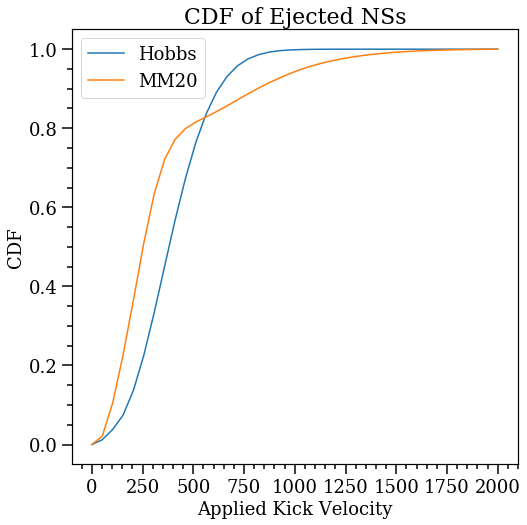

In [77]:
f, ax1= plt.subplots(1, 1,  figsize=(8,8)) 
hobbs_cdf_norm = hobbs_cdf/max(hobbs_cdf)

mm_cdf_norm = mm_cdf/max(mm_cdf)

plt.plot(vels, hobbs_cdf_norm, label='Hobbs')
plt.plot(vels, mm_cdf_norm, label='MM20')

layoutAxes(ax=ax1, nameX='Applied Kick Velocity',\
           nameY='CDF')
plt.title("CDF of Ejected NSs", fontsize=fl)
plt.legend(fontsize=fm)

# plt.xlim(0, 100)

plt.show()

# Period-Eccentricity Distribution

In [32]:
dco_type='BHNS'
# dco_type='BNS'

In [33]:
hobbs_ecc = mask_type(hobbs_ecc_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_sma = mask_type(hobbs_sma_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_m1 = mask_type(hobbs_m1_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_m2 = mask_type(hobbs_m2_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)

print(len(hobbs_ecc))

hobbs_period = sma_to_period(hobbs_sma, hobbs_m1, hobbs_m2)
print((hobbs_period))

6622
[0.0011286  0.00202565 0.00167708 ... 0.00221799 0.0009781  0.00090037]


In [ ]:
mm_ecc = mask_type(mm_ecc_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_sma = mask_type(mm_sma_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_m1 = mask_type(mm_m1_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_m2 = mask_type(mm_m2_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)

print(len(mm_ecc))

mm_period = sma_to_period(mm_sma, mm_m1, mm_m2)
# print((mm_period))

In [ ]:
f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

ms=10


layoutAxes(ax=ax, nameX='Eccentricity',\
           nameY='Semi-major axis [AU]')

plt.scatter(hobbs_ecc, hobbs_sma, s=ms, label='Hobbs')
plt.scatter(mm_ecc, mm_sma, s=ms, label='Mandel Muller')

plt.title(f"{dco_type} mergers", fontsize=fm)

lgnd = plt.legend(bbox_to_anchor=(1, 1), scatterpoints=1, fontsize=fs)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
    
# plt.semilogy()
plt.ylim(1e-3, 1e-1)
# plt.xlim(0.4, 0.6)
plt.grid()
plt.show()


In [ ]:
f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

ms=10


layoutAxes(ax=ax, nameX='Eccentricity',\
           nameY='Period [yr]')

plt.scatter(hobbs_ecc, hobbs_period, s=ms, label='Hobbs')
plt.scatter(mm_ecc, mm_period, s=ms, label='Mandel Muller')

plt.title(f"{dco_type} mergers", fontsize=fm)


lgnd = plt.legend(bbox_to_anchor=(1, 1), scatterpoints=1, fontsize=fs)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
    
# plt.loglog()
# plt.semilogy()
plt.ylim(-1e-5, 1e-2)
plt.grid()
plt.show()